This notebook visualizes the realized energy savings rates from Industrial Assessment Center (IAC) recommendations.

The [Industrial Assessment Centers](https://iac.university) operate under a program of the U.S. Department of Energy that provides no-cost energy assessments to small and medium-sized manufacturers. The data used in this analysis comes from the IAC database, which contains information on the recommendations made during these assessments, including their implementation status.

## Import Libraries

In [4]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from pathlib import Path

In [6]:
# Establish a connection to the DuckDB database
db_path = Path.cwd() / "database" / "iac.duckdb"
conn = duckdb.connect(str(db_path))

In [7]:
df = pd.read_sql("SELECT * FROM iac_integrated", conn)
df['main_code'] = df['main_code'].astype(str)

/var/folders/nq/3pr9r7y53tl05ffs53l8nqfh0000gn/T/ipykernel_56100/2020076242.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM iac_integrated", conn)


In [8]:
df.columns

Index(['superid', 'id', 'ar_number', 'appcode', 'arc2', 'impstatus', 'impcost',
       'source_rank', 'sourccode', 'conserved', 'sourconsv', 'saved', 'rebate',
       'incremntal', 'fy', 'ic_capital', 'ic_other', 'payback', 'bptool',
       'id_1', 'center', 'fy_1', 'sic', 'naics', 'state', 'sales', 'employees',
       'plant_area', 'products', 'produnits', 'prodlevel', 'prodhours',
       'numars', 'source_code', 'plant_cost', 'plant_usage', 'year', 'state_1',
       'emission_type', 'ec_emission_factor', 'main_code', 'main_description',
       'sub_code', 'sub_description', 'detail_code', 'detail_description',
       'specific_code', 'specific_description', 'emissions_avoided',
       'ec_price_per_kWh'],
      dtype='object')

In [9]:
# Vizualization Question: For different recommendation types what is their implementation rate normalized to the number of recommendations.
# pct. of electricity savings from implemented recommendations per audit /all potential savings per given audit 
# groupped by 2 digit arc (e.g. 2.4 motor systems) over the total period

# Prepare the data
df_ec = df[['superid', 'id', 'fy', 'main_code', 'main_description',  'sub_code', 'sub_description', 'detail_code', 'detail_description',
       'specific_code', 'specific_description', 'impstatus', 'conserved', 'ec_price_per_kWh']].drop_duplicates()

df_ec = df_ec[df_ec['conserved']>0]

# Grouped sum of implemented savings (where impstatus == 'I')
# Implemented savings
implemented = (
    df_ec[df_ec['impstatus'] == 'I']
    .groupby(['main_code', 'id'])['conserved']
    .sum()
    .rename('implemented_savings')
)

# Total savings
potential = (
    df_ec.groupby(['main_code', 'id'])['conserved']
    .sum()
    .rename('total_savings')
)

# Combine and calculate percentage
summary = pd.concat([implemented, potential], axis=1).fillna(0)
summary['pct_savings'] = summary['implemented_savings'] / summary['total_savings']

## Visualize realized energy savings rates with a dumbbell plot

In [10]:

# Count recommendations by main_code and impstatus
counts = df_ec.groupby(['main_description', 'impstatus']).size().unstack(fill_value=0)

# Normalize by total
counts['total'] = counts.sum(axis=1)
counts['implemented_norm'] = counts.get('I', 0) / counts['total']
counts['not_implemented_norm'] = counts.get('N', 0) / counts['total']


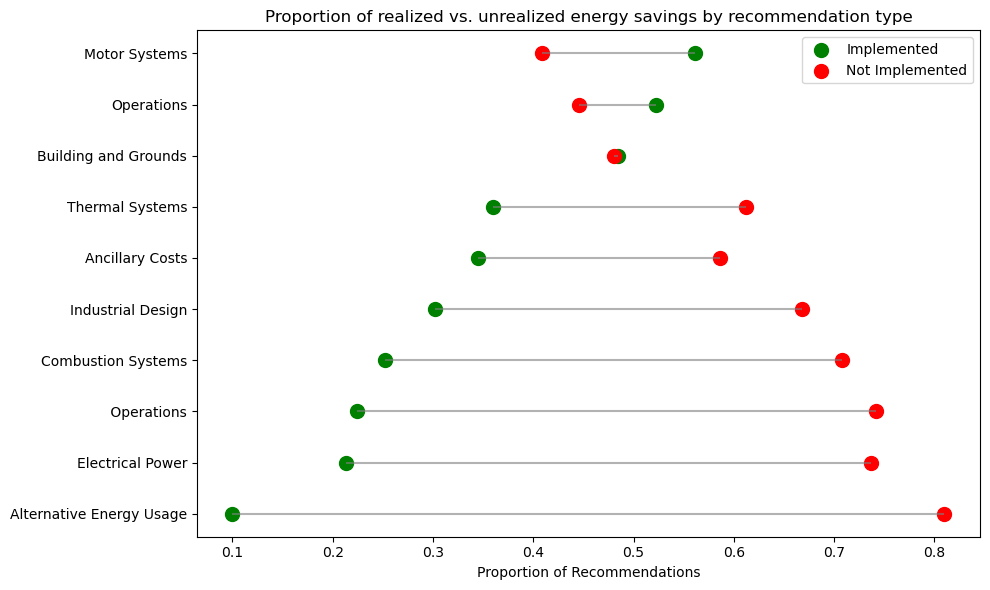

<Figure size 640x480 with 0 Axes>

In [12]:
# Create a dumbbell plot
# Sort by implemented_norm
counts = counts.sort_values('implemented_norm', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Defibe dumbbell lines
ax.hlines(y=counts.index, 
          xmin=counts['not_implemented_norm'], 
          xmax=counts['implemented_norm'], 
          color='gray', 
          alpha=0.6)

# Add dots
ax.scatter(counts['implemented_norm'], counts.index, color='green', label='Implemented', s=100)
ax.scatter(counts['not_implemented_norm'], counts.index, color='red', label='Not Implemented', s=100)

# Add labels and title
ax.set_xlabel('Proportion of Recommendations')
ax.set_title('Proportion of realized vs. unrealized energy savings by recommendation type')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

plt.savefig("realized_vs_not_realized_energy_savings.png", dpi=300, bbox_inches='tight')


In [112]:
conn.close()